<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchtext==0.6.0
!pip install spacy
!pip install --upgrade pydantic spacy typing_extensions

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0


#### **데이터 전처리(Preprocessing)**

* **spaCy 라이브러리**: 문장의 토큰화(tokenization), 태깅(tagging) 등의 전처리 기능을 위한 라이브러리
  * 영어(Engilsh)와 독일어(Deutsch) 전처리 모듈 설치

In [3]:
!pip install typing_extensions==4.4.0
import typing_extensions
from importlib import reload
reload(typing_extensions)
!pip install azure.ai.ml

  Using cached typing_extensions-4.4.0-py3-none-any.whl.metadata (7.2 kB)
Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azure-core 1.30.1 requires typing-extensions>=4.6.0, but you have typing-extensions 4.4.0 which is incompatible.
pydantic 2.6.4 requires typing-extensions>=4.6.1, but you have typing-extensions 4.4.0 which is incompatible.
pydantic-core 2.16.3 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.4.0 which is incompatible.
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.11.0-py3-none-any.whl (34 kB)
  Att

In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm


import spacy

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_de = spacy.load('de_core_news_sm') # 독일어 토큰화(tokenization)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.3 MB/s eta 0:00:0000:01:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 9.6 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 간단히 토큰화(tokenization) 기능 써보기
tokenized = spacy_en.tokenizer("I am a graduate student, and my name is Sarah.")

for i, token in enumerate(tokenized):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: am
인덱스 2: a
인덱스 3: graduate
인덱스 4: student
인덱스 5: ,
인덱스 6: and
인덱스 7: my
인덱스 8: name
인덱스 9: is
인덱스 10: Sarah
인덱스 11: .


* 영어(English) 및 독일어(Deutsch) **토큰화 함수** 정의

In [6]:
# 독일어(Deutsch) 문장을 토큰화 하는 함수 (순서를 뒤집지 않음)
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

# 영어(English) 문장을 토큰화 하는 함수
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

* **필드(field)** 라이브러리를 이용해 데이터셋에 대한 구체적인 전처리 내용을 명시
* Seq2Seq 모델과는 다르게 <b>batch_first 속성의 값을 True로 설정</b>
* 번역 목표
    * 소스(SRC): 독일어
    * 목표(TRG): 영어

#### * BucketIterator 사용하면 데이터를 배치처리할 때, 유사한 길이의 시퀀스끼리 그룹화해서 처리 가능 => 불필요한 패딩 최소화
- 데이터셋 정의 -> Field 객체 이용해 데이터 전처리 방법 정의 -> BucketIterator 생성 및 로드
- 데이터로더 대신 BucketIterator 사용

In [36]:
from torchtext.data import Field, BucketIterator, Dataset, Example
import os
import gzip
import torch


SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

source_path = '/opt/workspace/Seohyeon/Projects/.data/multi30k/SRC'
target_path ='/opt/workspace/Seohyeon/Projects/.data/multi30k/TRG'


def Create_Dataset(src_dir, trg_dir):
    examples = []
    with gzip.open(src_dir, 'rt', encoding='utf-8') as src_file, \
        gzip.open(trg_dir, 'rt', encoding='utf-8') as trg_file:
        
        for src_line, trg_line in zip(src_file, trg_file):
            examples.append(Example.fromlist([src_line.strip(), trg_line.strip()], fields=[('src', SRC), ('trg', TRG)])) # strip(): 문자열 양 끝 공백 제거 / fromlist(): Example 객체 생성

    # Dataset 생성
    dataset = Dataset(examples, fields={'src': SRC, 'trg': TRG})
    return dataset

def Create_iterator(dataset, BATCH_SIZE):
    iterator, = BucketIterator.splits(
        (dataset,),  # 데이터셋을 튜플 형태로 제공
        batch_size = BATCH_SIZE,
        sort_within_batch = True,
        sort_key = lambda x: len(x.src),  # src 길이에 따라 정렬
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )
    return iterator

train_dataset = Create_Dataset(os.path.join(source_path, 'train.en.gz'), os.path.join(target_path, 'train.de.gz'))
valid_dataset = Create_Dataset(os.path.join(source_path, 'val.en.gz'), os.path.join(target_path, 'val.de.gz'))
test_dataset = Create_Dataset(os.path.join(source_path, 'test_2016_flickr.en.gz'), os.path.join(target_path, 'test_2016_flickr.de.gz'))

# BucketIterator 사용
train_iterator = Create_iterator(train_dataset, BATCH_SIZE=128)
valid_iterator = Create_iterator(valid_dataset, BATCH_SIZE=128)
test_iterator = Create_iterator(test_dataset, BATCH_SIZE=128)

In [46]:

for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 21])
인덱스 0: 2
인덱스 1: 4
인덱스 2: 546
인덱스 3: 14
인덱스 4: 22
인덱스 5: 4
인덱스 6: 0
인덱스 7: 277
인덱스 8: 67
인덱스 9: 14
인덱스 10: 10
인덱스 11: 31
인덱스 12: 8
인덱스 13: 4
인덱스 14: 1136
인덱스 15: 70
인덱스 16: 18
인덱스 17: 27
인덱스 18: 1837
인덱스 19: 5
인덱스 20: 3


In [38]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


In [39]:
# 학습 데이터 중 하나를 선택해 출력
print(train_dataset.examples[30].src)  # src 속성에 직접 접근
print(train_dataset.examples[30].trg)  # trg 속성에 직접 접근



['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']
['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']


* **필드(field)** 객체의 **build_vocab** 메서드를 이용해 영어와 독어의 단어 사전을 생성
  * **최소 2번 이상** 등장한 단어만을 선택
  * 토큰화 전처리가 끝나면, 각 단어에 고유한 정수를 매핑해주는 integer encoding 작업이 필요.
  * 이 전처리를 위해서는 단어집합을 먼저 만들어줘야하고, .build_vocab()을 사용해서 단어 집합 생성 가능함

In [42]:
def tokenize(text):
    return text.split()

# 데이터셋 준비
src_data = [example.src for example in train_dataset.examples]
trg_data = [example.trg for example in train_dataset.examples]

# 어휘 구축
SRC.build_vocab(src_data, min_freq=2)
TRG.build_vocab(trg_data, min_freq=2)
print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 5972
len(TRG): 7874


In [43]:
# 단어집합을 만들었다면, TEXT.vocab.stoi를 통해 현재 단어 집합의 단어와 매핑된 고유한 정수를 출력 가능

print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

print(SRC.vocab.stoi)

0
1
2
3
6366
7769
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f70cf5c9070>>, {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3, 'a': 4, '.': 5, 'in': 6, 'the': 7, 'on': 8, 'man': 9, 'is': 10, 'and': 11, 'of': 12, 'with': 13, ',': 14, 'woman': 15, 'two': 16, 'are': 17, 'to': 18, 'people': 19, 'at': 20, 'an': 21, 'wearing': 22, 'young': 23, 'white': 24, 'shirt': 25, 'black': 26, 'his': 27, 'while': 28, 'blue': 29, 'men': 30, 'sitting': 31, 'girl': 32, 'red': 33, 'boy': 34, 'dog': 35, 'standing': 36, 'playing': 37, 'group': 38, 'street': 39, 'down': 40, 'walking': 41, 'front': 42, 'her': 43, 'holding': 44, 'one': 45, 'three': 46, 'water': 47, 'by': 48, 'women': 49, 'green': 50, 'little': 51, 'up': 52, 'for': 53, 'looking': 54, 'child': 55, 'outside': 56, 'as': 57, 'large': 58, 'through': 59, 'yellow': 60, 'brown': 61, 'children': 62, 'person': 63, 'from': 64, 'their': 65, 'ball': 66, 'hat': 67, 'into': 68, 'small': 69, 'next': 70, 'other': 71, '

#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [47]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [48]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의
    * 입력과 출력의 차원이 같음
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정

In [49]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정

In [50]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

#### **디코더(Decoder) 레이어 아키텍처**

* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어 사용
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용

In [51]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **디코더(Decoder) 아키텍처**

* 전체 디코더 아키텍처
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있음
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용

In [52]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **트랜스포머(Transformer) 아키텍처**

* 최종적인 전체 트랜스포머(Transformer) 모델을 정의
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성

In [53]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

#### **학습(Training)**

* 하이퍼 파라미터 설정 및 모델 초기화

In [54]:
INPUT_DIM = len(SRC.vocab) # 7964
OUTPUT_DIM = len(TRG.vocab) # 9762
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [64]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

* **모델 가중치 파라미터 초기화**

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,573,058 trainable parameters


In [66]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5972, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

* 학습 및 평가 함수 정의

In [67]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [68]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [69]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스()는 제외
            # 입력을 할 때는 부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0()은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

* 학습(training) 및 검증(validation) 진행
    * **학습 횟수(epoch)**: 10

In [70]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [71]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 10s
	Train Loss: 4.384 | Train PPL: 80.147
	Validation Loss: 3.199 | Validation PPL: 24.507
Epoch: 02 | Time: 0m 9s
	Train Loss: 2.888 | Train PPL: 17.958
	Validation Loss: 2.431 | Validation PPL: 11.374
Epoch: 03 | Time: 0m 9s
	Train Loss: 2.255 | Train PPL: 9.534
	Validation Loss: 2.033 | Validation PPL: 7.638
Epoch: 04 | Time: 0m 9s
	Train Loss: 1.851 | Train PPL: 6.366
	Validation Loss: 1.805 | Validation PPL: 6.079
Epoch: 05 | Time: 0m 10s
	Train Loss: 1.571 | Train PPL: 4.813
	Validation Loss: 1.680 | Validation PPL: 5.367
Epoch: 06 | Time: 0m 9s
	Train Loss: 1.365 | Train PPL: 3.916
	Validation Loss: 1.588 | Validation PPL: 4.893
Epoch: 07 | Time: 0m 10s
	Train Loss: 1.198 | Train PPL: 3.312
	Validation Loss: 1.551 | Validation PPL: 4.715
Epoch: 08 | Time: 0m 10s
	Train Loss: 1.062 | Train PPL: 2.892
	Validation Loss: 1.528 | Validation PPL: 4.611
Epoch: 09 | Time: 0m 9s
	Train Loss: 0.950 | Train PPL: 2.587
	Validation Loss: 1.546 | Validation PPL: 4.694
Ep

In [79]:
# 학습된 모델 저장
import torch
model_path = '/opt/workspace/Seohyeon/Projects/pretrained_model/transformer_german_to_english.pt'
torch.save(model, model_path)

#### **모델 최종 테스트(testing) 결과 확인**
- PPL: perplexity 
- 언어모델의 성능 평가에 사용
- 모델이 시퀀스의 다음 단어를 예측하는 데 얼마나 확신을 갖고 있는지를 수치적으로 나타냄 (값이 낮을수록 좋은 성능)
- 손실함수의 지수로 계산

In [80]:
model = torch.load(model_path)

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.550 | Test PPL: 4.710


#### **나만의 데이터로 모델 사용해보기**

* 테스트 데이터셋을 이용해 모델 테스트 진행

In [81]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de')  # 독일어 모델 로드
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [86]:
example_idx = 5

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['a', 'man', 'in', 'light', 'colored', 'clothing', 'photographs', 'a', 'group', 'of', 'men', 'wearing', 'dark', 'suits', 'and', 'hats', 'standing', 'around', 'a', 'woman', 'dressed', 'in', 'a', 'strapless', 'gown', '.']
타겟 문장: ['ein', 'hell', 'gekleideter', 'mann', 'fotografiert', 'eine', 'gruppe', 'von', 'männern', 'in', 'dunklen', 'anzügen', 'und', 'mit', 'hüten', ',', 'die', 'um', 'eine', 'frau', 'in', 'einem', 'trägerlosen', 'kleid', 'herum', 'stehen', '.']
전체 소스 토큰: ['<sos>', 'a', 'man', 'in', 'light', 'colored', 'clothing', 'photographs', 'a', 'group', 'of', 'men', 'wearing', 'dark', 'suits', 'and', 'hats', 'standing', 'around', 'a', 'woman', 'dressed', 'in', 'a', 'strapless', 'gown', '.', '<eos>']
소스 문장 인덱스: [2, 4, 9, 6, 301, 321, 213, 1233, 4, 38, 12, 30, 22, 217, 616, 11, 274, 36, 81, 4, 15, 72, 6, 4, 0, 2298, 5, 3]
모델 출력 결과: ein mann in hellen farben gekleidet , steht in einer gruppe von männern und <unk> steht auf einer gruppe . <eos>


* 어텐션 맵(Attention Map) 시각화

In [83]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    # 출력할 그림 크기 조절
    fig = plt.figure(figsize=(15, 25))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [84]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
타겟 문장: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'i', 'm', 'freien', '.']
전체 소스 토큰: ['<sos>', 'a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']
소스 문장 인덱스: [2, 4, 488, 11, 43, 23, 1388, 295, 4, 364, 178, 56, 5, 3]
모델 출력 결과: eine mutter und ihr junge singen vor einem schönen tag ein lied . <eos>


/tmp/ipykernel_24505/3016299776.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
/tmp/ipykernel_24505/3016299776.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + translation)


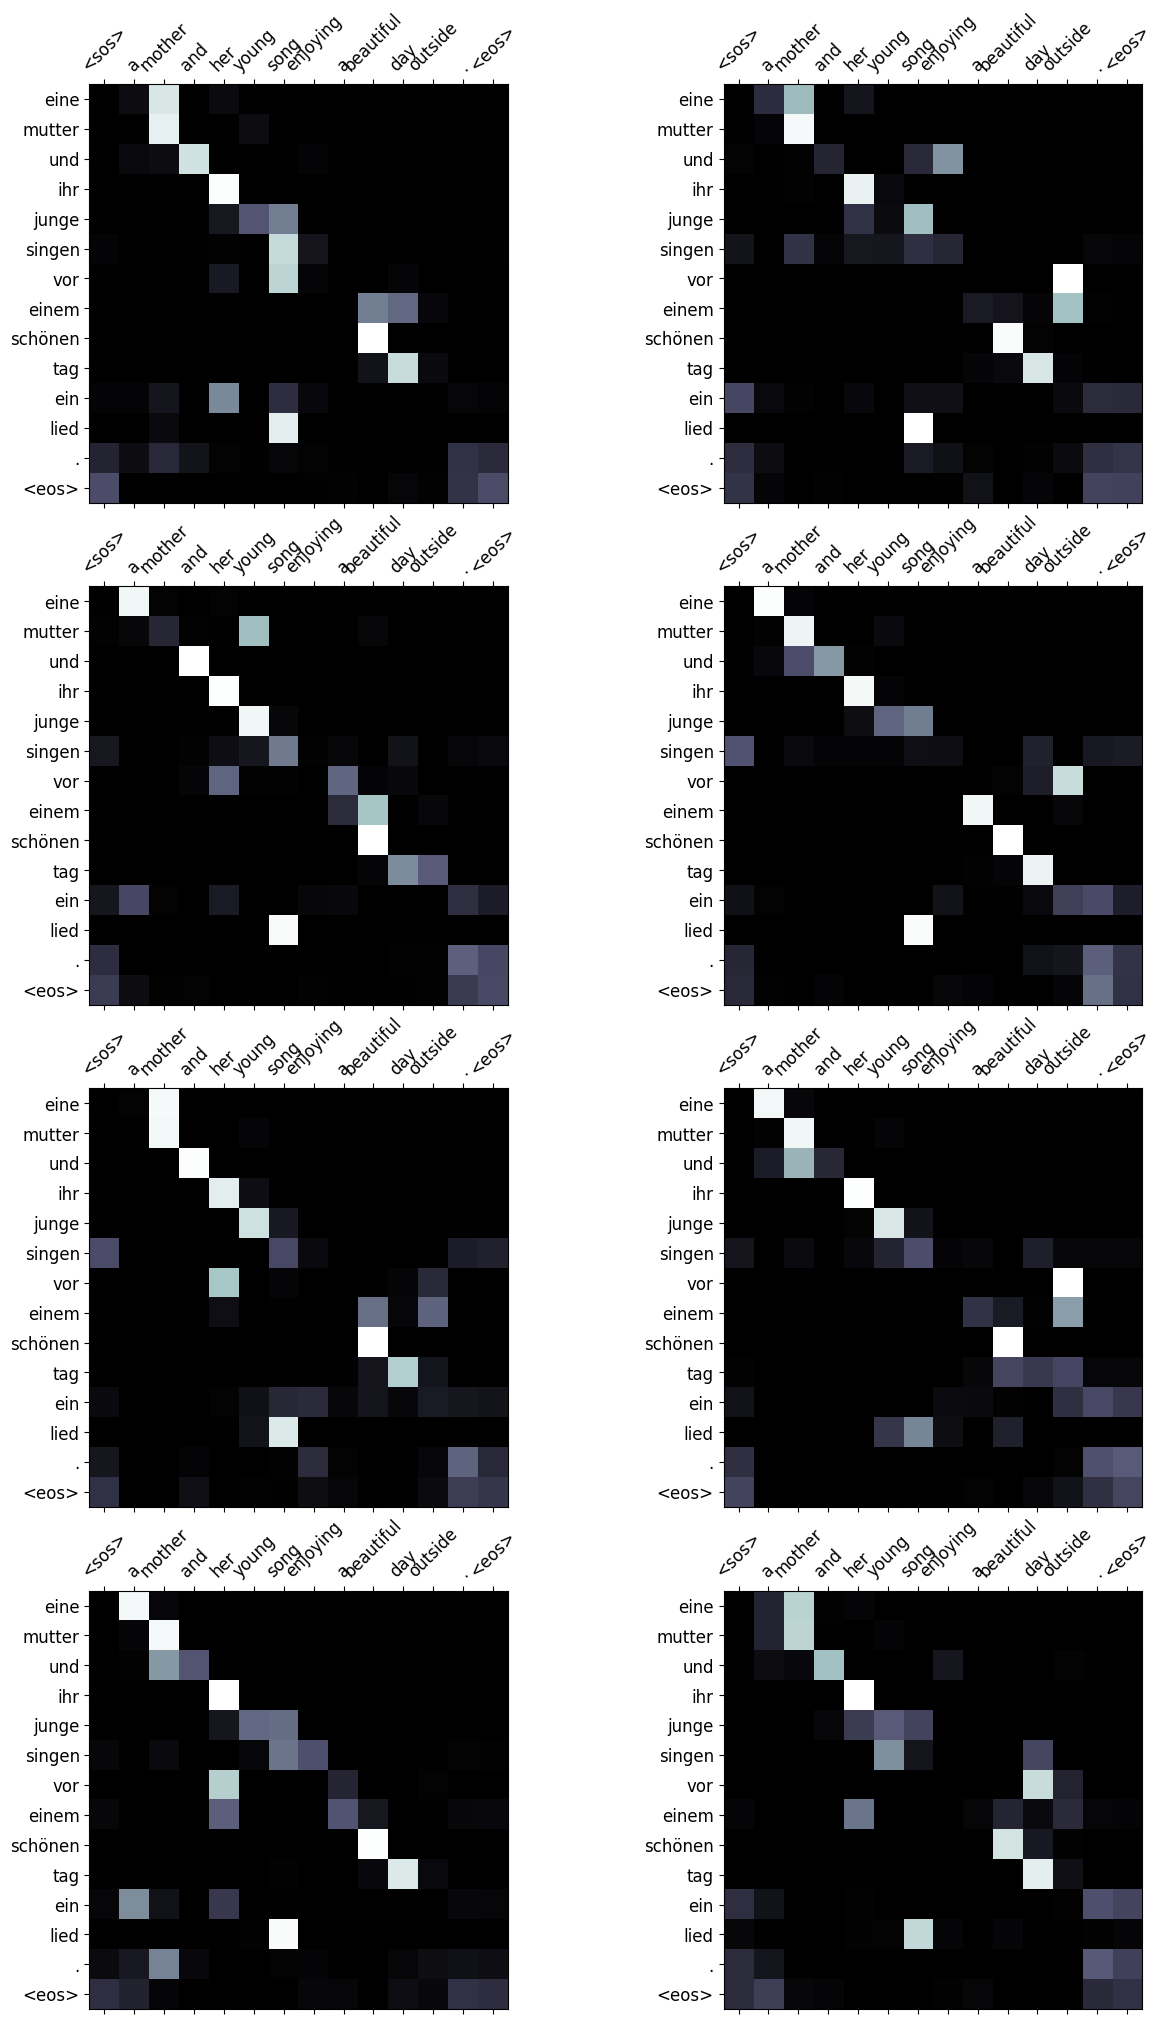

In [85]:
display_attention(src, translation, attention)

#### <b>BLEU Score 계산</b>

* 학습된 트랜스포머(Transformer) 모델의 BLEU 스코어 계산
- BLEU: 기계번역결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교

In [87]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f'Individual BLEU1 score = {individual_bleu1_score*100:.2f}') 
    print(f'Individual BLEU2 score = {individual_bleu2_score*100:.2f}') 
    print(f'Individual BLEU3 score = {individual_bleu3_score*100:.2f}') 
    print(f'Individual BLEU4 score = {individual_bleu4_score*100:.2f}') 

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}') 
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}') 
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}') 
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}') 

In [88]:
show_bleu(test_dataset, SRC, TRG, model, device)

[100/1000]
예측: ['eine', 'gruppe', 'von', 'asiatischen', 'kindern', 'sitzt', 'auf', 'stühlen', 'auf', 'blauen', 'stühlen', '.']
정답: ['eine', 'gruppe', 'überwiegend', 'asiatischer', 'kinder', 'sitzt', 'in', 'arbeitsnischen', 'verteilt', 'auf', 'blauen', 'stühlen', '.']
[200/1000]
예측: ['eine', 'gruppe', 'von', 'menschen', 'ist', 'ganz', 'mit', 'regenschirmen', 'bedeckt', '.']
정답: ['alle', 'personen', 'in', 'der', 'gruppe', 'stehen', 'unter', 'regenschirmen', '.']
[300/1000]
예측: ['ein', 'torhüter', 'in', 'einem', 'gelben', 'feld', 'befindet', 'sich', 'auf', 'dem', 'tor', '.']
정답: ['ein', 'torwart', 'in', 'einem', 'gelben', 'trikot', 'schützt', 'das', 'tor', '.']
[400/1000]
예측: ['zwei', 'kleine', 'kinder', 'sind', 'auf', 'sand', '.']
정답: ['zwei', 'kleine', 'kinder', 'auf', 'dem', 'sand', '.']
[500/1000]
예측: ['zwei', '<unk>', 'hunde', 'rennen', 'durch', 'den', 'schnee', '.']
정답: ['zwei', 'mittelgroße', 'hunde', 'laufen', 'über', 'den', 'schnee', '.']
[600/1000]
예측: ['eine', 'gruppe', 'von', 